In [1]:
import pytse_client as tse
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.linalg import pinv
# tickers = tse.download(symbols="all", write_to_csv=True)

Device = ("cuda"
          if torch.cuda.is_available()
          else "cpu"
)
print(f"Using {Device} device")
days_history=100
days_predict=30

Using cuda device


In [2]:
class Model(nn.Module):
   def __init__(self,input_days,cell_size,hid_size,output_size,num_layers,p):
      super().__init__()
      self.lstm = nn.LSTM(input_days,cell_size,num_layers,proj_size=hid_size,dropout=p,batch_first=True)
      self.fc = nn.Sequential(
         nn.Linear(hid_size,2*hid_size),
         nn.LeakyReLU(),
         nn.Linear(2*hid_size,hid_size),
         nn.LeakyReLU(),
         nn.Linear(hid_size,output_size),
         nn.LeakyReLU()
       )
   

   def forward(self,input,h0,c0):
      output,(h_out,c_out) = self.lstm(input,(h0,c0))
      output = self.fc(output)
      return output,(h_out,c_out)


cell_size = 64
hidden_size = 32
num_layers = 3
batch_size = 64

h0 = torch.zeros([num_layers,batch_size,hidden_size],device=Device)
c0 = torch.zeros([num_layers,batch_size,cell_size],device=Device)
model = Model(1,cell_size,hidden_size,1,num_layers,0.8)
model.to(device=Device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
gama=0.99
W_gama=torch.diag(torch.tensor([gama**(1*i) for i in range(days_predict)],device=Device))
for p in model.parameters():
    #p.data.fill_(torch.randn([])/10)
    print(np.shape(p))

torch.Size([256, 1])
torch.Size([256, 32])
torch.Size([256])
torch.Size([256])
torch.Size([32, 64])
torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([256])
torch.Size([256])
torch.Size([32, 64])
torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([256])
torch.Size([256])
torch.Size([32, 64])
torch.Size([64, 32])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [3]:
names = ["آباد","آبادا","آپ","اپرداز","آساس","افرا","اهرم","انرژی","بترانس","بنیرو","پترول","وبملت"]
#names = [names[0]]
#sym="وبملت"
stock_num = len(names)
stocks = []
for ii in range(stock_num):
    sym = names[ii]
    ticker=tse.Ticker(sym)
    length=ticker.history.shape[0]
    train_length = int(np.floor(length*0.70))
    test_length = length - train_length

    # Now we extract some portion of the first sequences of data for train
    X_train=np.zeros([train_length - days_history - days_predict , days_history,5])
    Y_train=np.zeros([train_length - days_history - days_predict , days_predict])
    for i in range(train_length - days_history - days_predict):
        m = ticker.history.loc[i : i + days_history - 1].to_numpy()
        first_day_price = m[0,9]
        X_train[i,:,:] = np.array([m[:,9]/first_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/first_day_price , m[:,3]/first_day_price]).T
        m = ticker.history.loc[i + days_history : i + days_history - 1 + days_predict].to_numpy()
        Y_train[i,:] = m[:,9]/first_day_price

    # Now we extract some portion of the last sequences of data for test
    X_test=np.zeros([test_length - days_predict , days_history, 5])
    Y_test=np.zeros([test_length - days_predict , days_predict])
    for i in range(test_length - days_predict):
        j = i + train_length - days_history
        m = ticker.history.loc[j : j + days_history - 1].to_numpy()
        first_day_price = m[0,9]
        X_test[i,:,:] = np.array([m[:,9]/first_day_price , m[:,7]/1e3 , m[:,6]/1e6 , m[:,2]/first_day_price , m[:,3]/first_day_price]).T
        m = ticker.history.loc[j + days_history : j + days_history - 1 + days_predict].to_numpy()
        Y_test[i,:] = m[:,9]/first_day_price

    train_arr = np.arange(train_length - days_history - days_predict - 1)
    train_idx = np.random.permutation(train_arr)
    X_train = X_train[train_idx]
    Y_train = Y_train[train_idx]

    test_arr = np.arange(test_length - days_predict - 1)
    test_idx = np.random.permutation(test_arr)
    X_test = X_test[test_idx]
    Y_test = Y_test[test_idx]
    
    X_train = torch.from_numpy(X_train).to(device=Device,dtype=torch.float32)
    Y_train = torch.from_numpy(Y_train).to(device=Device,dtype=torch.float32)

    X_test = torch.from_numpy(X_test).to(device=Device,dtype=torch.float32)
    Y_test = torch.from_numpy(Y_test).to(device=Device,dtype=torch.float32)

    stocks.append([X_test,Y_test,X_train,Y_train])

In [4]:
train_Losses=[]
test_Losses=[]
for epoch in range(10):
    model.train()
    train_loss=torch.tensor(0,dtype=torch.float32)
    N_total_train = 0
    loss_sum = 0
    for ii in range(stock_num):
        [_,_,X_train,Y_train] = stocks[ii]
        N_train = int(np.floor(X_train.size(0)/batch_size))
        N_total_train += N_train
        for i in range(N_train):
            x = X_train[i*batch_size:(i+1)*batch_size,:,0].unsqueeze(-1)
            y = Y_train[i*batch_size:(i+1)*batch_size,:].unsqueeze(-1)
            optimizer.zero_grad()
            _,(h,c) = model(x,h0,c0)
            output,(h,c) = model(y,h,c)
            loss_train = loss_fn(output,y)
            loss_train.backward()
            optimizer.step()
            train_loss += loss_train.detach().item()
    train_Losses.append( train_loss/(N_total_train*batch_size))
   
    model.eval()
    test_loss=torch.tensor(0,dtype=torch.float32)
    test_acc=torch.tensor(0,dtype=torch.float32)
    output_ = torch.zeros([batch_size,days_predict,1],device=Device)
    with torch.no_grad():
        N_total_test = 0
        for ii in range(stock_num):
            [X_test,Y_test,_,_] = stocks[ii]
            N_test = int(np.floor(X_test.size(0)/batch_size))
            N_total_test += N_test
            for i in range(N_test):
                x = X_test[i*batch_size:(i+1)*batch_size,:,0].unsqueeze(-1)
                y = Y_test[i*batch_size:(i+1)*batch_size,:].detach()
                output,(h,c) = model(x,h0,c0)
                output_[:,0,0] = output[:,-1,0]
                for i in range(days_predict-1):
                    o,(h,c) = model(output_[:,i,:].unsqueeze(1),h,c)
                    output_[:,i+1,:] = o.squeeze(1)

                loss_test = loss_fn(output_,y.unsqueeze(-1))
                test_loss += loss_test.to('cpu')
                test_acc += torch.sum(1-torch.abs((y@W_gama-output_.squeeze(-1)@W_gama)/y@W_gama)).detach().item()
    test_Losses.append( test_loss/(N_total_test*batch_size) )
    accuracy = test_acc / (N_total_test*batch_size*days_predict) *100
    print(f'{epoch}: train loss is {train_Losses[epoch]:.4f} & test loss is {test_Losses[epoch]:.4f} & accuracy is %{accuracy:.2f}')

0: train loss is 0.0020 & test loss is 0.0035 & accuracy is %60.72
1: train loss is 0.0002 & test loss is 0.0029 & accuracy is %63.38
2: train loss is 0.0002 & test loss is 0.0029 & accuracy is %66.27
3: train loss is 0.0002 & test loss is 0.0037 & accuracy is %63.49
4: train loss is 0.0001 & test loss is 0.0031 & accuracy is %64.31
5: train loss is 0.0001 & test loss is 0.0046 & accuracy is %65.07
6: train loss is 0.0001 & test loss is 0.0043 & accuracy is %64.63
7: train loss is 0.0001 & test loss is 0.0039 & accuracy is %58.38
8: train loss is 0.0001 & test loss is 0.0065 & accuracy is %62.45
9: train loss is 0.0001 & test loss is 0.0046 & accuracy is %64.54


In [5]:
z = torch.zeros([batch_size,days_predict],device=Device)
const_acc = 0
const_loss = 0
N_total_test = 0
for ii in range(stock_num): 
    [X_test,Y_test,_,_] = stocks[ii]
    N_test = int(np.floor(X_test.size(0)/batch_size))
    N_total_test += N_test  
    for i in range(N_test):
        y = Y_test[i*batch_size:(i+1)*batch_size,:].detach()
        out = z + y[:,0].unsqueeze(1)
        loss_const = loss_fn(y,out)
        const_loss += loss_const.detach().item()
        const_acc += torch.sum(1-torch.abs(y@W_gama-out@W_gama)/y@W_gama).detach().item()
const_loss /= N_total_test*batch_size
accuracy = const_acc / (N_total_test*batch_size*days_predict) *100
print(f'constant price method loss is {const_loss:.4f} accuracy is %{accuracy:.2f}')



random_strock = np.random.randint(stock_num)
[X_test,Y_test,X_train,Y_train] = stocks[random_strock]
test_length = X_test.size(0)
iidx=np.random.randint(test_length,size=[5,2])

constant price method loss is 0.0015 accuracy is %84.72


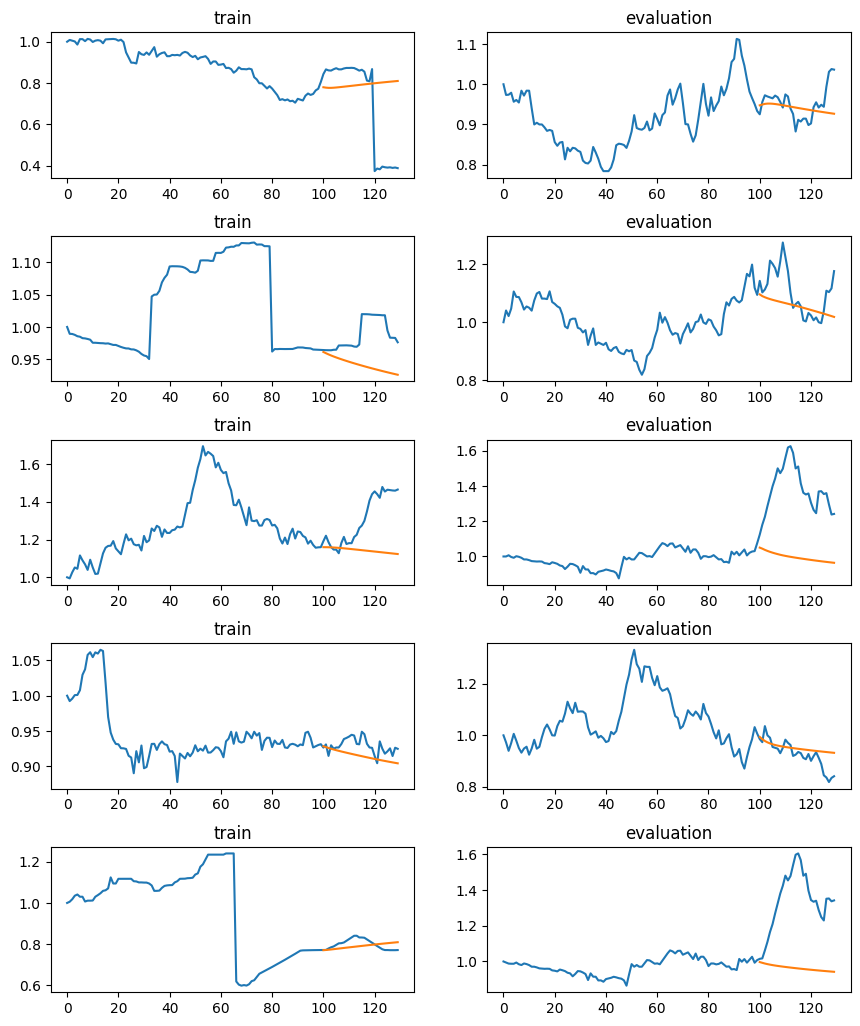

In [6]:
plt.figure(figsize=[10,12])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)
with torch.no_grad():
   yyy = torch.zeros([days_predict,1],device=Device)
   model.eval()
   for i in range(5):
      plt.subplot(5,2,2*i+1)
      r=iidx[i,0]
      yy=torch.concatenate([X_train[r,:,0].cpu(),Y_train[r,:].cpu()]) 
      xx=np.arange(days_history+days_predict)
      plt.plot(xx,yy)
      tempp=X_train[r,:,0].unsqueeze(-1)
      o,(h,c) = model(tempp,h0[:,0,:].clone(),c0[:,0,:].clone())
      yyy[0,:] = o[-1,0]
      for ii in range(days_predict-1):
         o,(h,c) = model(yyy[ii,:].unsqueeze(0),h,c)
         yyy[ii+1,:] = o
      plt.plot(xx[days_history:days_history+days_predict] ,yyy.cpu().numpy() )
      plt.title('train')


      plt.subplot(5,2,2*i+2)
      r=iidx[i,1]
      yy=torch.concatenate([X_test[r,:,0].cpu(),Y_test[r,:].cpu()]) 
      xx=np.arange(days_history+days_predict)
      plt.plot(xx,yy)
      tempp=X_test[r,:,0].unsqueeze(-1)
      o,(h,c) = model(tempp,h0[:,0,:].clone(),c0[:,0,:].clone())
      yyy[0,:] = o[-1,0]
      for ii in range(days_predict-1):
         o,(h,c) = model(yyy[ii,:].unsqueeze(0),h,c)
         yyy[ii+1,:] = o
      plt.plot(xx[days_history:days_history+days_predict] ,yyy.cpu().numpy() )
      plt.title('evaluation')





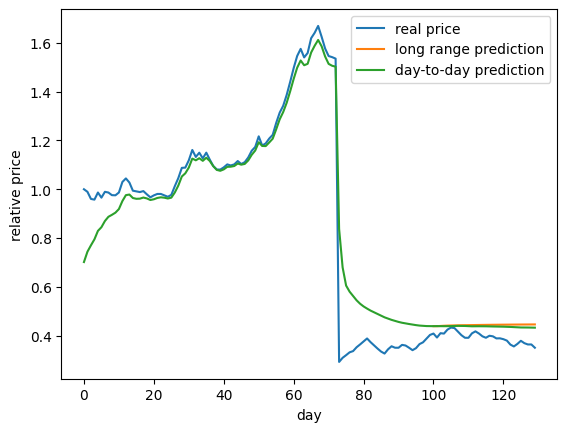

In [7]:
r=4
with torch.no_grad():
   yyy = torch.zeros([days_predict,1],device=Device)
   model.eval()
   yy=torch.concatenate([X_train[r,:,0].cpu(),Y_train[r,:].cpu()]) 
   xx=np.arange(days_history+days_predict)
   plt.plot(xx,yy)
   tempp=X_train[r,:,0].unsqueeze(-1)
   o,(h,c) = model(tempp,h0[:,0,:].clone(),c0[:,0,:].clone())
   yyy[0,:] = o[-1,0]
   for ii in range(days_predict-1):
      o,(h,c) = model(yyy[ii,:].unsqueeze(0),h,c)
      yyy[ii+1,:] = o
   plt.plot(xx[days_history:days_history+days_predict] ,yyy.cpu().numpy() )
   plt.xlabel("day")
   plt.ylabel("relative price")

   yyyy,_ = model(yy.unsqueeze(-1).to(Device),h0[:,0,:].clone(),c0[:,0,:].clone()) 
   plt.plot(xx,yyyy.to('cpu').numpy())
   plt.legend(['real price','long range prediction','day-to-day prediction'])
